The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==0.14.3
!pip install -U mxnet-cu101mkl==1.6.0.post0  # updating mxnet to at least v1.6


     |████████████████████████████████| 712.3MB 27kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


# Image Classification (CIFAR-10) on Kaggle
:label:`sec_kaggle_cifar10`

So far, we have been using Gluon's `data` package to directly obtain image datasets in the tensor format. In practice, however, image datasets often exist in the format of image files. In this section, we will start with the original image files and organize, read, and convert the files to the tensor format step by step.

We performed an experiment on the CIFAR-10 dataset in :numref:`sec_image_augmentation`.
This is an important data
set in the computer vision field. Now, we will apply the knowledge we learned in
the previous sections in order to participate in the Kaggle competition, which
addresses CIFAR-10 image classification problems. The competition's web address
is

> https://www.kaggle.com/c/cifar-10

:numref:`fig_kaggle_cifar10` shows the information on the competition's webpage. In order to submit the results, please register an account on the Kaggle website first.

![CIFAR-10 image classification competition webpage information. The dataset for the competition can be accessed by clicking the "Data" tab.](https://github.com/d2l-ai/d2l-en-colab/blob/master/img/kaggle_cifar10.png?raw=1)
:width:`600px`
:label:`fig_kaggle_cifar10`

First, import the packages or modules required for the competition.


In [2]:
import collections
from d2l import mxnet as d2l
import math
from mxnet import autograd, gluon, init, npx
from mxnet.gluon import nn
import os
import pandas as pd
import shutil
import time

npx.set_np()

## Obtaining and Organizing the Dataset

The competition data is divided into a training set and testing set. The training set contains $50,000$ images. The testing set contains $300,000$ images, of which $10,000$ images are used for scoring, while the other $290,000$ non-scoring images are included to prevent the manual labeling of the testing set and the submission of labeling results. The image formats in both datasets are PNG, with heights and widths of 32 pixels and three color channels (RGB). The images cover $10$ categories: planes, cars, birds, cats, deer, dogs, frogs, horses, boats, and trucks. The upper-left corner of Figure 9.16 shows some images of planes, cars, and birds in the dataset.

### Downloading the Dataset

After logging in to Kaggle, we can click on the "Data" tab on the CIFAR-10 image classification competition webpage shown in :numref:`fig_kaggle_cifar10` and download the dataset by clicking the "Download All" button. After unzipping the downloaded file in `../data`, and unzipping `train.7z` and `test.7z` inside it, you will find the entire dataset in the following paths:

* ../data/cifar-10/train/[1-50000].png
* ../data/cifar-10/test/[1-300000].png
* ../data/cifar-10/trainLabels.csv
* ../data/cifar-10/sampleSubmission.csv

Here folders `train` and `test` contain the training and testing images respectively, `trainLabels.csv` has labels for the training images, and `sample_submission.csv` is a sample of submission. 

To make it easier to get started, we provide a small-scale sample of the dataset: it contains the first $1000$ training images and $5$ random testing images.
To use the full dataset of the Kaggle competition, you need to set the following `demo` variable to `False`.


In [3]:
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# If you use the full dataset downloaded for the Kaggle competition, set
# `demo` to False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

### Organizing the Dataset

We need to organize datasets to facilitate model training and testing. Let us first read the labels from the csv file. The following function returns a dictionary that maps the filename without extension to its label.


In [4]:
#@save
def read_csv_labels(fname):
    """Read fname to return a name to label dictionary."""
    with open(fname, 'r') as f:
        # Skip the file header line (column name)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# classes:', len(set(labels.values())))

# training examples: 1000
# classes: 10


Next, we define the `reorg_train_valid` function to segment the validation set from the original training set. The argument `valid_ratio` in this function is the ratio of the number of examples in the validation set to the number of examples in the original training set. In particular, let $n$ be the number of images of the class with the least examples, and $r$ be the ratio, then we will use $\max(\lfloor nr\rfloor,1)$ images for each class as the validation set.  Let us use `valid_ratio=0.1` as an example. Since the original training set has $50,000$ images, there will be $45,000$ images used for training and stored in the path "`train_valid_test/train`" when tuning hyperparameters, while the other $5,000$ images will be stored as validation set in the path "`train_valid_test/valid`". After organizing the data, images of the same class will be placed under the same folder so that we can read them later.


In [5]:
#@save
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    d2l.mkdir_if_not_exist(target_dir)
    shutil.copy(filename, target_dir)

#@save    
def reorg_train_valid(data_dir, labels, valid_ratio):
    # The number of examples of the class with the least examples in the
    # training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        # Copy to train_valid_test/train_valid with a subfolder per class
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            # Copy to train_valid_test/valid
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # Copy to train_valid_test/train
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

The `reorg_test` function below is used to organize the testing set to facilitate the reading during prediction.


In [6]:
#@save    
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

Finally, we use a function to call the previously defined `read_csv_labels`, `reorg_train_valid`, and `reorg_test` functions.


In [7]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

We only set the batch size to $4$ for the demo dataset. During actual training and testing, the complete dataset of the Kaggle competition should be used and `batch_size` should be set to a larger integer, such as $128$. We use $10\%$ of the training examples as the validation set for tuning hyperparameters.


In [8]:
batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

## Image Augmentation

To cope with overfitting, we use image augmentation. For example, by adding `transforms.RandomFlipLeftRight()`, the images can be flipped at random. We can also perform normalization for the three RGB channels of color images using `transforms.Normalize()`. Below, we list some of these operations that you can choose to use or modify depending on requirements.


In [9]:
transform_train = gluon.data.vision.transforms.Compose([
    # Magnify the image to a square of 40 pixels in both height and width
    gluon.data.vision.transforms.Resize(40),
    # Randomly crop a square image of 40 pixels in both height and width to
    # produce a small square of 0.64 to 1 times the area of the original
    # image, and then shrink it to a square of 32 pixels in both height and
    # width
    gluon.data.vision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor(),
    # Normalize each channel of the image
    gluon.data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

In order to ensure the certainty of the output during testing, we only perform normalization on the image.


In [10]:
transform_test = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                           [0.2023, 0.1994, 0.2010])])

## Reading the Dataset

Next, we can create the `ImageFolderDataset` instance to read the organized dataset containing the original image files, where each example includes the image and label.


In [11]:
train_ds, valid_ds, train_valid_ds, test_ds = [
    gluon.data.vision.ImageFolderDataset(
        os.path.join(data_dir, 'train_valid_test', folder))
    for folder in ['train', 'valid', 'train_valid', 'test']]

We specify the defined image augmentation operation in `DataLoader`. During training, we only use the validation set to evaluate the model, so we need to ensure the certainty of the output. During prediction, we will train the model on the combined training set and validation set to make full use of all labelled data.


In [12]:
train_iter, train_valid_iter = [gluon.data.DataLoader(
    dataset.transform_first(transform_train), batch_size, shuffle=True, 
    last_batch='discard') for dataset in (train_ds, train_valid_ds)]

valid_iter = gluon.data.DataLoader(
    valid_ds.transform_first(transform_test), batch_size, shuffle=False, 
    last_batch='discard')

test_iter = gluon.data.DataLoader(
    test_ds.transform_first(transform_test), batch_size, shuffle=False, 
    last_batch='keep')

## Defining the Model

Here, we build the residual blocks based on the `HybridBlock` class, which is
slightly different than the implementation described in
:numref:`sec_resnet`. This is done to improve execution efficiency.


In [13]:
class Residual(nn.HybridBlock):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1,
                               strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1,
                                   strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def hybrid_forward(self, F, X):
        Y = F.npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.npx.relu(Y + X)

Next, we define the ResNet-18 model.


In [14]:
def resnet18(num_classes):
    net = nn.HybridSequential()
    net.add(nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
            nn.BatchNorm(), nn.Activation('relu'))

    def resnet_block(num_channels, num_residuals, first_block=False):
        blk = nn.HybridSequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(Residual(num_channels))
        return blk

    net.add(resnet_block(64, 2, first_block=True),
            resnet_block(128, 2),
            resnet_block(256, 2),
            resnet_block(512, 2))
    net.add(nn.GlobalAvgPool2D(), nn.Dense(num_classes))
    return net

The CIFAR-10 image classification challenge uses 10 categories. We will perform Xavier random initialization on the model before training begins.


In [15]:
def get_net(devices):
    num_classes = 10
    net = resnet18(num_classes)
    net.initialize(ctx=devices, init=init.Xavier())
    return net

loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Defining the Training Functions

We will select the model and tune hyperparameters according to the model's performance on the validation set. Next, we define the model training function `train`. We record the training time of each epoch, which helps us compare the time costs of different models.


In [16]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(
                net, features, labels.astype('float32'), loss, trainer,
                devices, d2l.split_batch)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0:
                animator.add(epoch + i / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpus(net, valid_iter, d2l.split_batch)
            animator.add(epoch + 1, (None, None, valid_acc))
    if valid_iter is not None:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}, '
              f'valid acc {valid_acc:.3f}')
    else:
        print(f'loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

## Training and Validating the Model

Now, we can train and validate the model. The following hyperparameters can be tuned. For example, we can increase the number of epochs. Because `lr_period` and `lr_decay` are set to 80 and 0.1 respectively, the learning rate of the optimization algorithm will be multiplied by 0.1 after every 80 epochs. For simplicity, we only train one epoch here.


loss nan, train acc 0.102, valid acc 0.100
163.4 examples/sec on [gpu(0)]


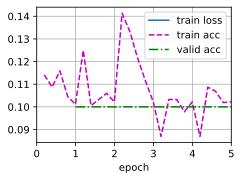

In [17]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.1, 5e-4
lr_period, lr_decay, net = 50, 0.1, get_net(devices)
net.hybridize()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

## Classifying the Testing Set and Submitting Results on Kaggle

After obtaining a satisfactory model design and hyperparameters, we use all training datasets (including validation sets) to retrain the model and classify the testing set.


loss nan, train acc 0.102
174.4 examples/sec on [gpu(0)]


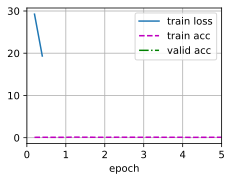

In [18]:
net, preds = get_net(devices), []
net.hybridize()
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.as_in_ctx(devices[0]))
    preds.extend(y_hat.argmax(axis=1).astype(int).asnumpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('submission.csv', index=False)

After executing the above code, we will get a "submission.csv" file. The format
of this file is consistent with the Kaggle competition requirements. The method
for submitting results is similar to method in :numref:`sec_kaggle_house`.

## Summary

* We can create an `ImageFolderDataset` instance to read the dataset containing the original image files.
* We can use convolutional neural networks, image augmentation, and hybrid programming to take part in an image classification competition.


## Exercises

1. Use the complete CIFAR-10 dataset for the Kaggle competition. Change the `batch_size` and number of epochs `num_epochs` to 128 and 100, respectively.  See what accuracy and ranking you can achieve in this competition.
1. What accuracy can you achieve when not using image augmentation?
1. Scan the QR code to access the relevant discussions and exchange ideas about the methods used and the results obtained with the community. Can you come up with any better techniques?


[Discussions](https://discuss.d2l.ai/t/379)
